In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('Playground BikeSharing')
# mlflow.set_experiment('MLflow BikeSharing')

# Load the dataset
hourData = pd.read_csv('bike+sharing+dataset/hour.csv')


In [137]:
def create_pipeline(

):
    numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
    categorical_features = ['season', 'mnth', 'hr', 'weekday', 'weathersit']

    numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', estimator)
    ])

    return pipeline


In [138]:
X = hourData.drop(['instant', 'dteday', 'casual', 'registered', 'cnt'], axis=1)
y = hourData['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [139]:
def evaluate_model(estimator, name, params=None):
    pipeline = create_pipeline(estimator)

    if params:
        pipeline = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='neg_root_mean_squared_error')

    with mlflow.start_run(run_name=name):
        pipeline.fit(X_train, y_train)
        y_preds = pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_preds))
        mae = mean_absolute_error(y_test, y_preds)
        r2 = r2_score(y_test, y_preds)

        mlflow.log_param("model", name)
        if params and hasattr(pipeline, "best_params_"):
            mlflow.log_params(pipeline.best_params_)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2", r2)
        mlflow.sklearn.log_model(pipeline, "model")

        print(f"{name} -- RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")

        # Create subplots
        fig, axes = plt.subplots(1, 2, figsize=(15, 10))

        # Scatterplot
        sns.scatterplot(x=y_test, y=y_preds, ax=axes[0])
        axes[0].set_xlabel("True Values")
        axes[0].set_ylabel("Predicted Values")
        axes[0].set_title(f"{name}: True vs Predicted Values (Scatter)")

        # Add a reference line (y = x) to the scatterplot
        min_val = min(y_test.min(), y_preds.min())
        max_val = max(y_test.max(), y_preds.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Perfect Prediction')
        axes[0].legend()

        # Lineplot with both y_test and y_preds
        step = 100
        sns.lineplot(x=range(0, len(y_test), step), y=y_test[::step], label="True Values", ax=axes[1], color='green')
        sns.lineplot(x=range(0, len(y_preds), step), y=y_preds[::step], label="Predicted Values", ax=axes[1], color='orange')
        # sns.lineplot(x=range(len(y_test)), y=y_test, label="True Values", ax=axes[1], color='green')
        # sns.lineplot(x=range(len(y_preds)), y=y_preds, label="Predicted Values", ax=axes[1], color='orange')
        axes[1].set_xlabel("Index")
        axes[1].set_ylabel("Values")
        axes[1].set_title(f"{name}: True vs Predicted Values (Line)")
        axes[1].legend()



2025/05/08 15:56:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression -- RMSE: 108.67, MAE: 77.84, R2: 0.63
🏃 View run LinearRegression at: http://localhost:5000/#/experiments/788929956922202818/runs/bacceb66fe05437f8576d8aad8983052
🧪 View experiment at: http://localhost:5000/#/experiments/788929956922202818


2025/05/08 15:58:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest -- RMSE: 78.02, MAE: 52.14, R2: 0.81
🏃 View run RandomForest at: http://localhost:5000/#/experiments/788929956922202818/runs/ee7b391b202f42adad387f7097be5ef7
🧪 View experiment at: http://localhost:5000/#/experiments/788929956922202818


2025/05/08 15:58:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost -- RMSE: 74.57, MAE: 51.09, R2: 0.82
🏃 View run XGBoost at: http://localhost:5000/#/experiments/788929956922202818/runs/d7c32b3865294ab0bc7952c911b44d4a
🧪 View experiment at: http://localhost:5000/#/experiments/788929956922202818


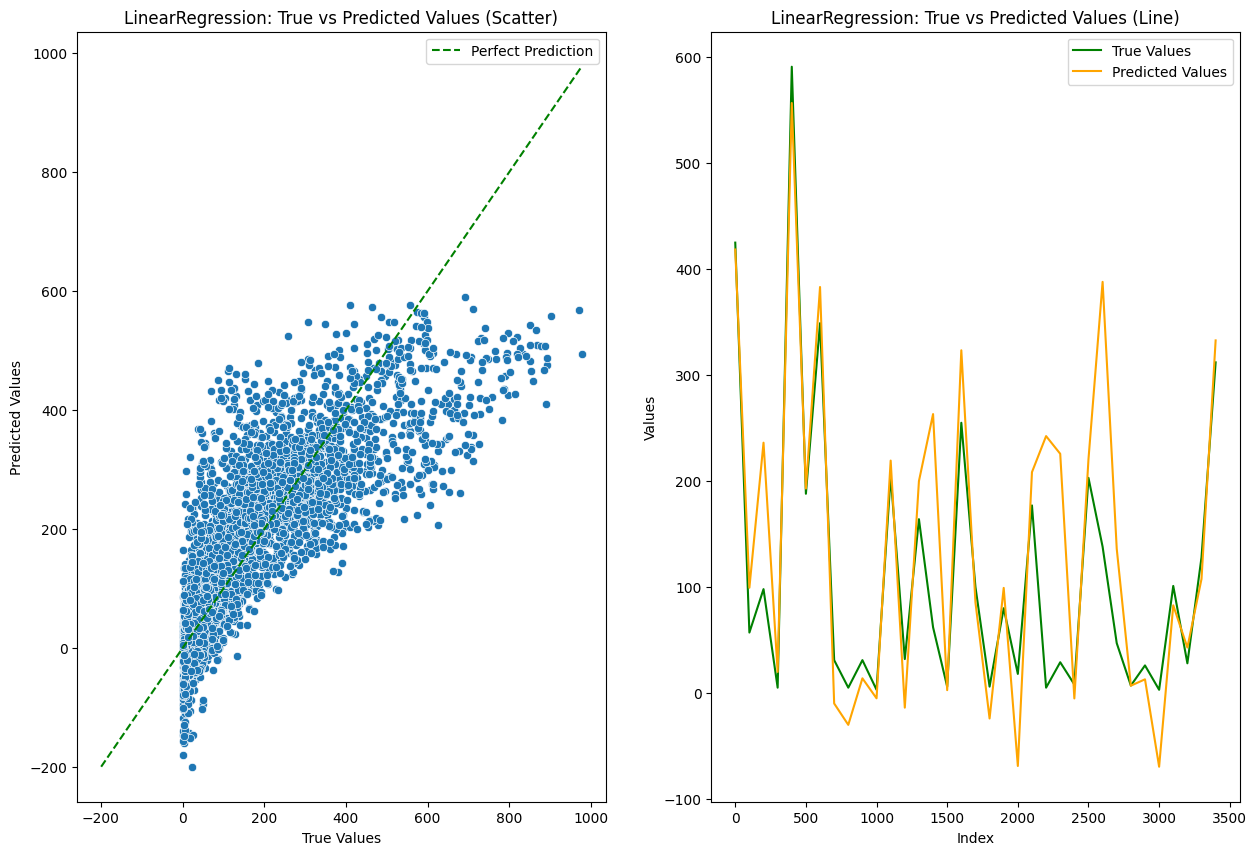

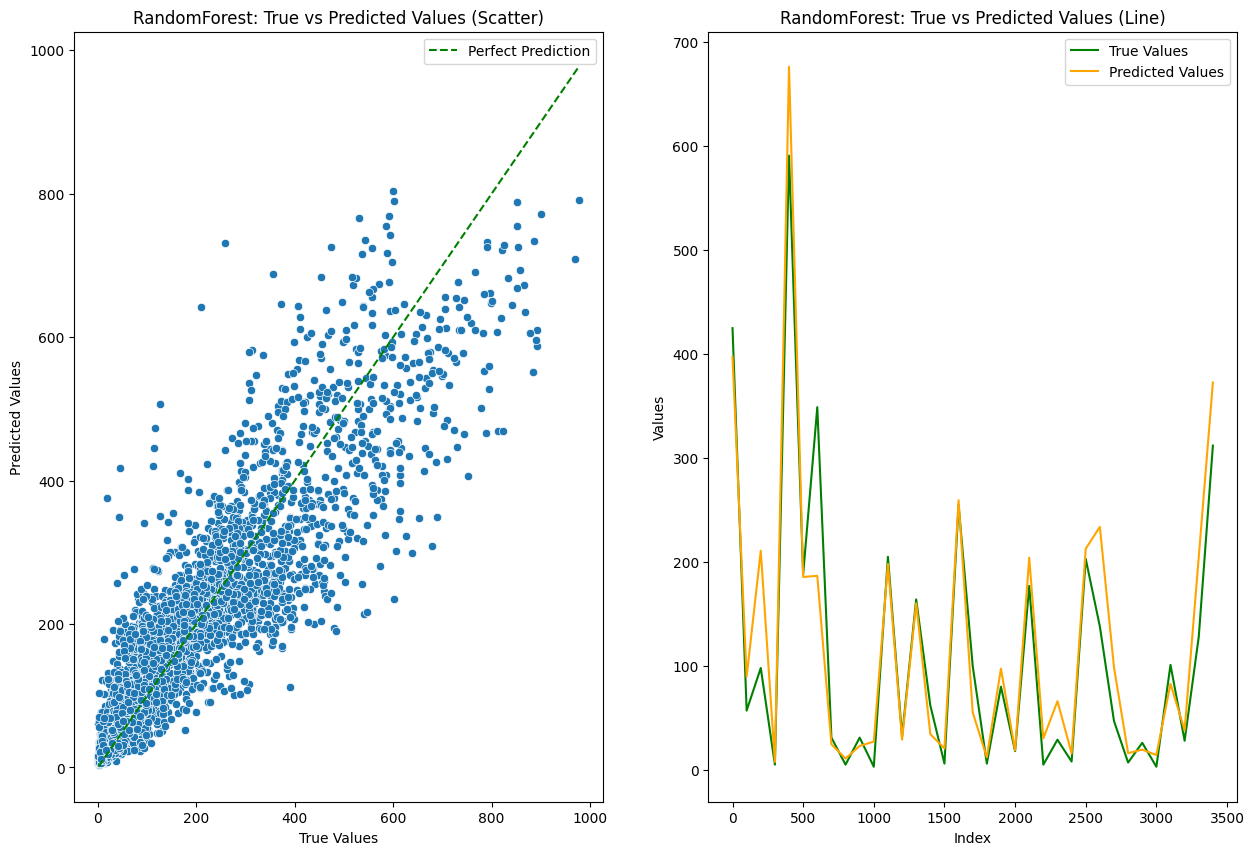

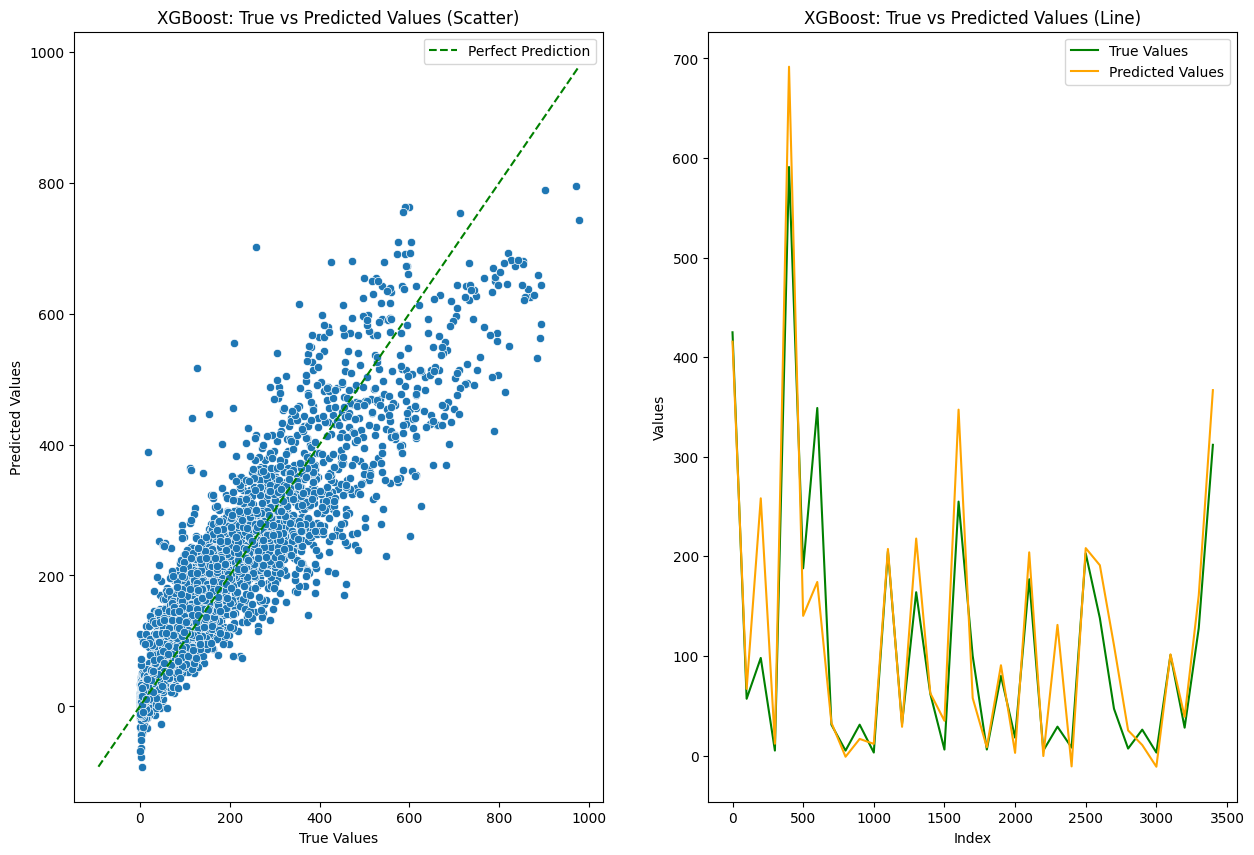

In [140]:
# Linear Regression
evaluate_model(LinearRegression(), "LinearRegression")

# Random Forest with GridSearch
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20]
}
evaluate_model(RandomForestRegressor(random_state=42), "RandomForest", rf_params)

# XGBoost with GridSearch
xgb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5]
}
evaluate_model(XGBRegressor(objective='reg:squarederror', random_state=42), "XGBoost", xgb_params)
